In [7]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

In [8]:
con = sqlite3.connect('./final.sqlite') # this is cleaned dataset
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('Reviews',)]


# Data Cleaning

In [0]:
n=25000

In [9]:
final = pd.read_sql_query("""
SELECT *
FROM reviews
""", con)[:n]

In [0]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [10]:
# Get a balanced dataset
negative_1500=final[final['Score']=='negative'][:1500]
positive_1500=final[final['Score']=='positive'][:1500]

In [11]:
final=pd.concat((negative_1500,positive_1500))

# Text preprocessing

1. Removal of HTML tags
2. Removal of punctuation marks and special characters
3. Conversion to lowercase
4. Removal of 2 letter words
5. Removal of numeric characters
6. Stopword removal
7. Snowball stemming

In [12]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:
from nltk.corpus import stopwords

In [0]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [0]:
stop_not_excluded = set(stopwords.words('english')) #set of stopwords
stop_not_included = stop_not_excluded.difference({'not'})
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

In [0]:
str1=None
str2=None
final_string_not_included=[]
final_string_not_excluded=[]
s=''
for sent in final['Text'].values:
    filtered_sentence_not_included=[]
    filtered_sentence_not_excluded=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if cleaned_words.lower() not in stop_not_included:
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence_not_included.append(s)
                if cleaned_words.lower() not in stop_not_excluded:
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence_not_excluded.append(s)
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence_not_included) #final string of cleaned words with 'not' included
    str2 = b" ".join(filtered_sentence_not_excluded) #final string of cleaned words with 'not' included
    #print("***********************************************************************")
    
    final_string_not_included.append(str1)
    final_string_not_excluded.append(str2)

In [0]:
final['Text_not_included'] = final_string_not_included
final['Text_not_excluded'] = final_string_not_excluded

In [0]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [0]:
final.head()['Text_not_included']

22620    b'dog love chicken product china wont buy anym...
22621    b'dog love saw pet store tag attach regard mad...
2547     b'use victor fli bait season cant beat great p...
2546     b'product avail www amazon com victor trap unr...
1145     b'receiv shipment could hard wait tri product ...
Name: Text_not_included, dtype: object

# Bag of words

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(2,2) ) #in scikit-learn
final_bigram_counts_all_included = count_vect.fit_transform(final['Text'].values)
final_bigram_counts_not_included = count_vect.fit_transform(final['Text_not_included'].values)
final_bigram_counts_not_excluded = count_vect.fit_transform(final['Text_not_excluded'].values)

In [0]:
arr=final_bigram_counts_all_included.getrow(6).toarray()
np.where(arr != 0)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 30673,  42396,  44201,  73272, 116165, 187575, 198495, 200615,
        249205, 250619, 260768, 302039, 309671, 345857, 358610, 358736,
        372748, 390779, 395244, 397990, 416200, 441422, 441555]))

In [0]:
arr[0,358736]

1

In [0]:
num_negative=len(final[final['Score']=='negative'].values)
num_positive=len(final[final['Score']=='positive'].values)

In [9]:
num_negative

1500

In [10]:
num_positive

1500

In [12]:
final_bigram_counts_not_excluded.get_shape()

(3000, 86167)

## Observation 
Keep p less than 1500

In [0]:
from sklearn.manifold import TSNE

In [0]:
p=100

In [0]:
model_all_included = TSNE(n_components=2, random_state=0, perplexity=p)
model_not_included = TSNE(n_components=2, random_state=0, perplexity=p)
model_not_excluded = TSNE(n_components=2, random_state=0, perplexity=p)

tsne_data_all_included = model_all_included.fit_transform(final_bigram_counts_all_included.toarray())
tsne_data_not_included = model_not_included.fit_transform(final_bigram_counts_not_included.toarray())
tsne_data_not_excluded = model_not_excluded.fit_transform(final_bigram_counts_not_excluded.toarray())

In [65]:
tsne_data_not_excluded

array([[-0.14882955,  0.83684134],
       [-1.0772611 , -0.46872702],
       [-0.7272085 ,  0.877955  ],
       ...,
       [-0.14414746, -0.04727471],
       [-0.11784831,  0.14492744],
       [-0.11721484,  0.14161293]], dtype=float32)

In [0]:
plot_all_included=pd.DataFrame(np.concatenate((tsne_data_all_included, np.transpose(np.array(final['Score'], ndmin=2))), axis=1), columns=['f1', 'f2', 'label'])
del tsne_data_all_included
plot_not_included=pd.DataFrame(np.concatenate((tsne_data_not_included, np.transpose(np.array(final['Score'], ndmin=2))), axis=1), columns=['f1', 'f2', 'label'])
del tsne_data_not_included
plot_not_excluded=pd.DataFrame(np.concatenate((tsne_data_not_excluded, np.transpose(np.array(final['Score'], ndmin=2))), axis=1), columns=['f1', 'f2', 'label'])
del tsne_data_not_excluded

In [77]:
plot_not_excluded.shape

(3000, 3)

In [78]:
plot_all_included[:3]

,f1,f2,label
0,-1.07917,0.52654,negative
1,1.16047,0.547074,negative
2,-1.03507,-1.26618,negative


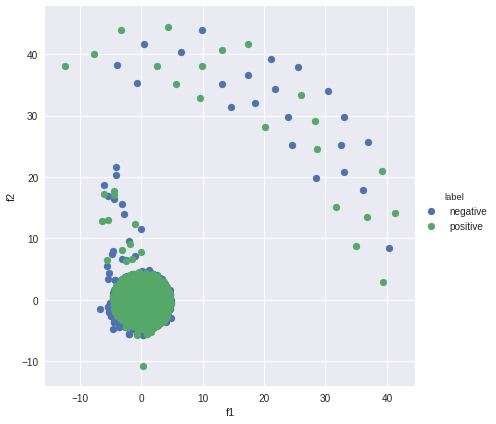

In [17]:
sns.FacetGrid(plot_all_included, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

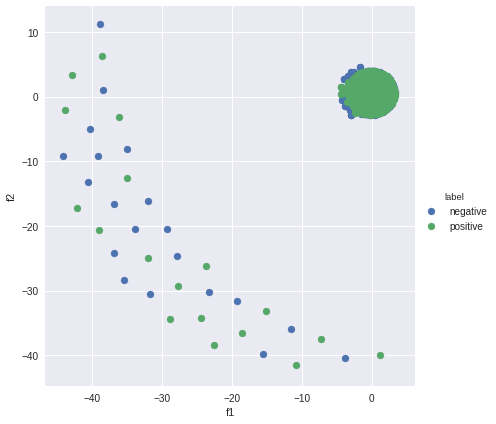

In [18]:
sns.FacetGrid(plot_not_included, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

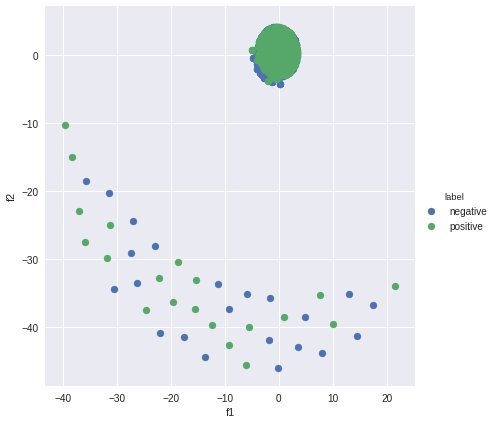

In [19]:
sns.FacetGrid(plot_not_excluded, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

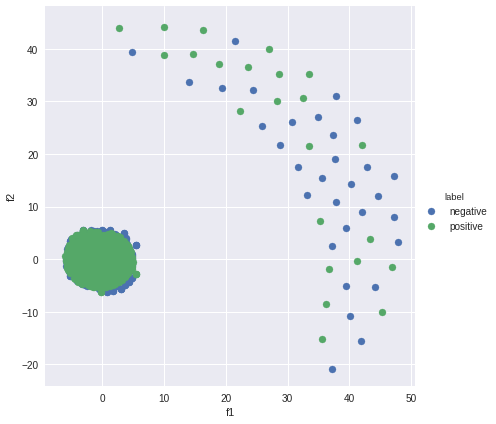

In [23]:
sns.FacetGrid(plot_all_included, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

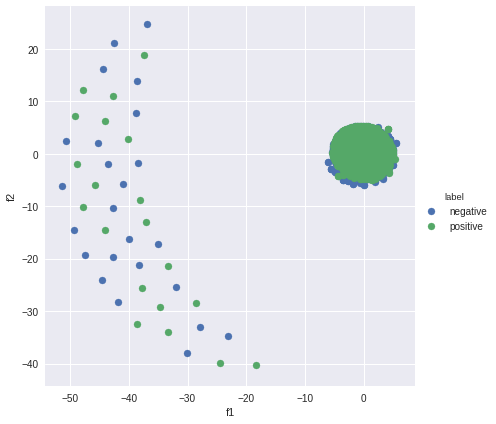

In [24]:
sns.FacetGrid(plot_not_included, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

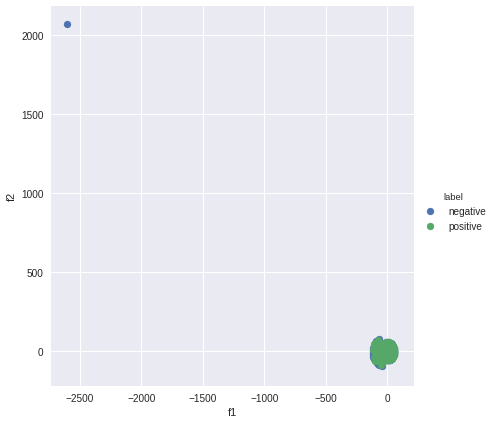

In [25]:
sns.FacetGrid(plot_not_excluded, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

# TF-IDF

In [0]:
from nltk.stem import SnowballStemmer
sno=SnowballStemmer('english')

In [0]:
# Stem the words without removing stopwords
text_stemmed=[]
for review in final['Text'].values:
    review=cleanhtml(review)
    stemmed_words=[]
    for punc_w in review.split():
        for w in cleanpunc(punc_w).split():
            if len(w)>2 and w.isalpha():
                stemmed=sno.stem(w.lower()).encode('utf8')
                stemmed_words.append(stemmed)
    stemmed_review=b' '.join(stemmed_words)
    text_stemmed.append(stemmed_review)
final['stemmed_text']=text_stemmed

In [41]:
final['Text'][1]

'Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.'

In [42]:
final['stemmed_text'][1]

b'our dog just love them saw them pet store and tag was attach regard them be made china and satisfi that they were safe'

In [0]:
tf_idf_vect_all_words_included = TfidfVectorizer(ngram_range=(2,2))
final_tf_idf_all_words_included = tf_idf_vect_all_words_included.fit_transform(final['stemmed_text'])

tf_idf_vect_all_stopwords_removed = TfidfVectorizer(ngram_range=(2,2))
final_tf_idf_not_excluded = tf_idf_vect_all_stopwords_removed.fit_transform(final['Text_not_excluded'])

tf_idf_vect_not_retained = TfidfVectorizer(ngram_range=(2,2))
final_tf_idf_not_included = tf_idf_vect_not_retained.fit_transform(final['Text_not_included'])

In [49]:
from sklearn.manifold import TSNE
p=1400

In [0]:
model_all_included = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=1500)
model_not_included = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=1500)
model_not_excluded = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=1500)

tsne_data_all_included = model_all_included.fit_transform(final_tf_idf_all_words_included.toarray())
tsne_data_not_included = model_not_included.fit_transform(final_tf_idf_not_included.toarray())
tsne_data_not_excluded = model_not_excluded.fit_transform(final_tf_idf_not_excluded.toarray())

In [0]:
plot_all_included=pd.DataFrame(np.concatenate((tsne_data_all_included, np.transpose(np.array(final['Score'], ndmin=2))), axis=1), columns=['f1', 'f2', 'label'])
del tsne_data_all_included
plot_not_included=pd.DataFrame(np.concatenate((tsne_data_not_included, np.transpose(np.array(final['Score'], ndmin=2))), axis=1), columns=['f1', 'f2', 'label'])
del tsne_data_not_included
plot_not_excluded=pd.DataFrame(np.concatenate((tsne_data_not_excluded, np.transpose(np.array(final['Score'], ndmin=2))), axis=1), columns=['f1', 'f2', 'label'])
del tsne_data_not_excluded

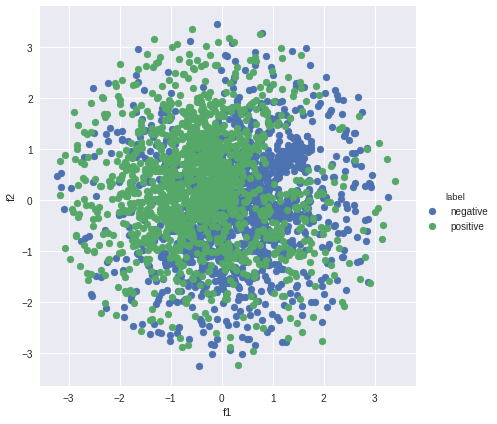

In [58]:
sns.FacetGrid(plot_all_included, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend() #1000

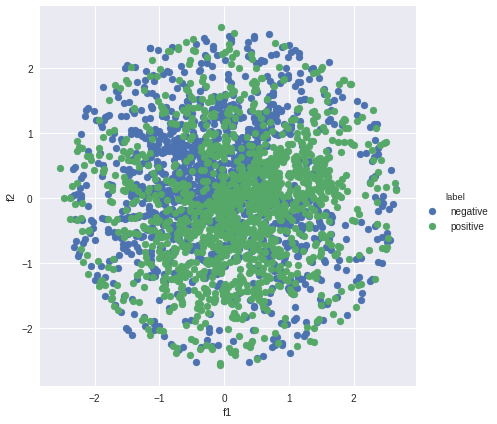

In [59]:
sns.FacetGrid(plot_not_included, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

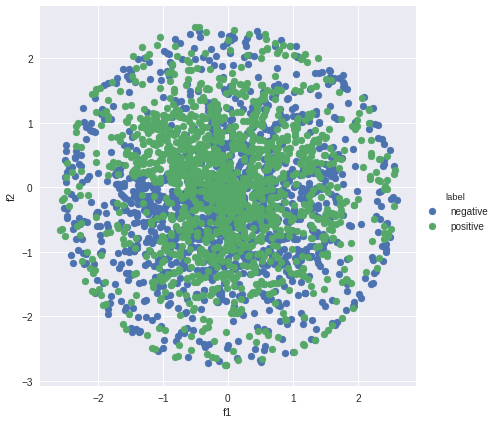

In [61]:
sns.FacetGrid(plot_not_excluded, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

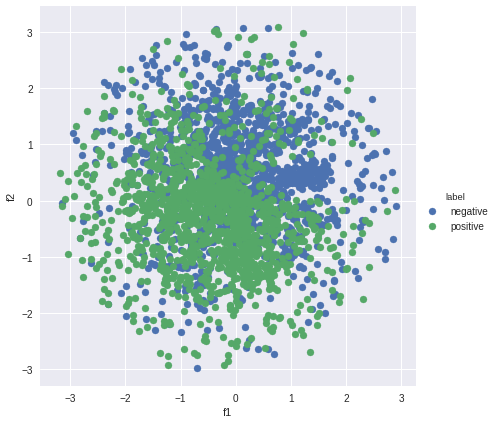

In [65]:
sns.FacetGrid(plot_all_included, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend() # 1250

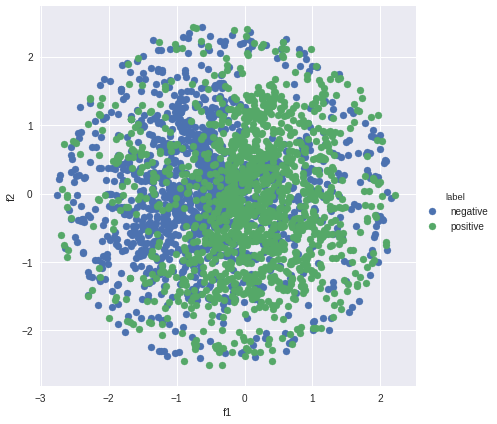

In [66]:
sns.FacetGrid(plot_not_included, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

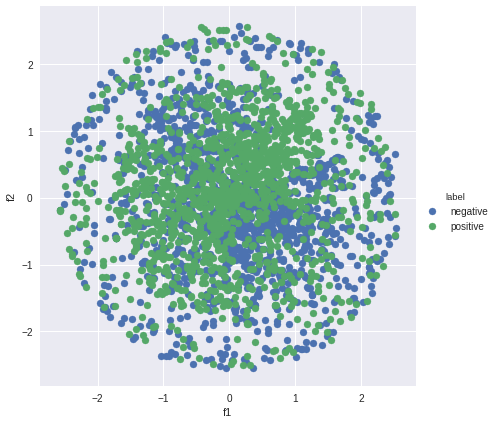

In [67]:
sns.FacetGrid(plot_not_excluded, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

# Observations
TF-IDF provides better separation of negative from positive reviews as we increase perplexity. It can also be seen that best results obtained when all words are included to form bigrams as compared to bigrams obtained by removing stopwords. If we exclude 'not' from list of stopwords, better results are obtained as compared to when 'not' is included as stopword.

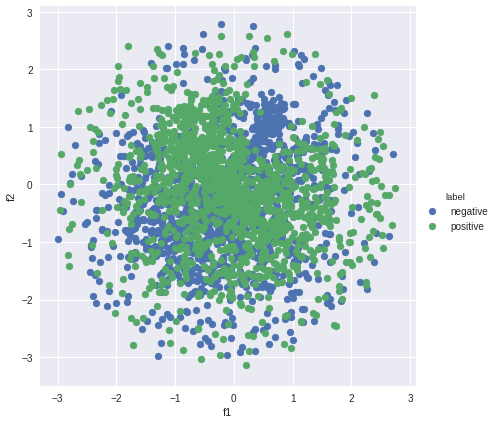

In [87]:
sns.FacetGrid(plot_all_included, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend() # 1400

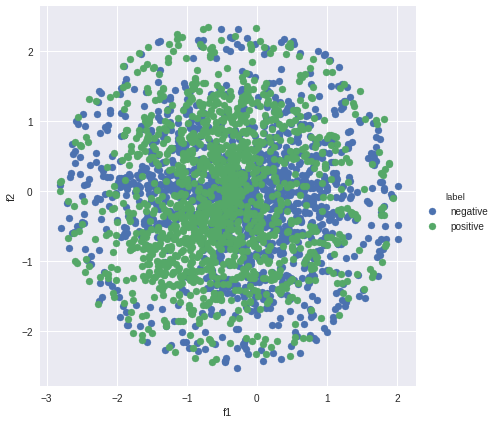

In [88]:
sns.FacetGrid(plot_not_included, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

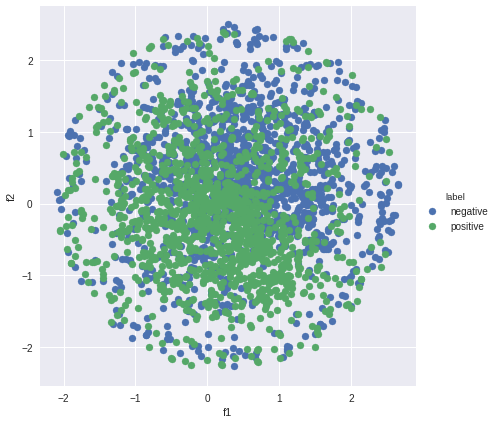

In [89]:
sns.FacetGrid(plot_not_excluded, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend()

# Conclusion
Best perplexity 1250 with 1500 iterations

# Average word2Vec with above obtained parameters for TSNE

In [13]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [24]:
clean_text=[]
for sent in list_of_sent:
    s=' '.join(sent)
    clean_text.append(s)

In [28]:
final['clean_text']=clean_text

In [14]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=1,size=50, workers=1)    

In [15]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler=StandardScaler()

In [134]:
np.shape(sent_vectors)

(3000, 50)

In [0]:
scaled=scaler.fit_transform(sent_vectors)
tsne_model=TSNE(perplexity=900, n_iter=1500)
tsne_data=tsne_model.fit_transform(scaled)

In [0]:
plot_tsne=pd.DataFrame(np.concatenate((tsne_data, np.transpose(np.array(final['Score'], ndmin=2))), axis=1), columns=['f1', 'f2', 'label'])

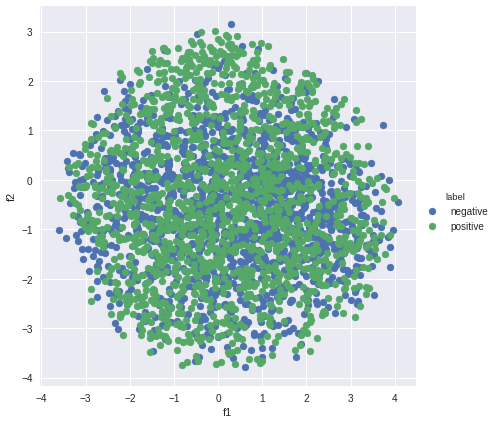

In [137]:
sns.FacetGrid(plot_tsne, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend() # p=1200

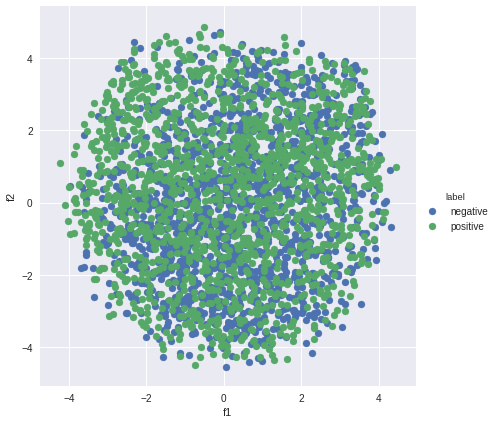

In [141]:
sns.FacetGrid(plot_tsne, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend() # p=900

# Conclusion
Average word2Vec does not yield good results

# TF-IDF word2Vec

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(final['clean_text'].values)

In [32]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
cnt=0
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
            cnt+=1
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [48]:
tfidf_sent_vectors[1500]

array([ 0.28067801, -0.19081185, -0.04260838,  0.28642985, -0.64746111,
       -0.64312387,  0.16066378,  0.33372795, -0.19374414, -0.41818326,
       -0.05702171,  0.12379148,  0.45517951, -0.26014962, -0.46599343,
       -0.57293554, -0.22492677,  0.46670954, -0.03482334, -0.99999671,
       -0.38334637,  0.17849195, -0.37276381,  0.99311478,  0.11574649,
       -0.03164939,  0.12387733, -0.31967458,  1.67181607, -0.11203611,
       -0.06784235,  0.69936647,  0.16618147,  0.97755205,  0.18302191,
        0.72372913,  0.44135196,  0.40731333, -0.9446863 ,  0.36938271,
        0.81940944,  0.50451965,  0.08794205,  0.39522043, -0.15154316,
        0.40906625, -0.20931151,  0.45765495,  0.78601216, -0.61179202])

In [76]:
from sklearn.preprocessing import MinMaxScaler
mmscaler=MinMaxScaler()

In [82]:
p=700

In [83]:
scaled=scaler.fit_transform(tfidf_sent_vectors)
model=TSNE(perplexity=p, n_iter=1500)

In [84]:
data=model.fit_transform(scaled)

In [85]:
plot=pd.DataFrame(np.concatenate((data, np.array(final.Score.values, ndmin=2).T), axis=1), columns=['f1','f2','label'])

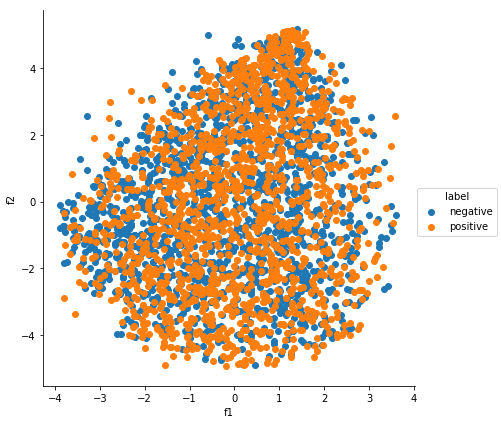

In [70]:
sns.FacetGrid(plot, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend() # p=1000

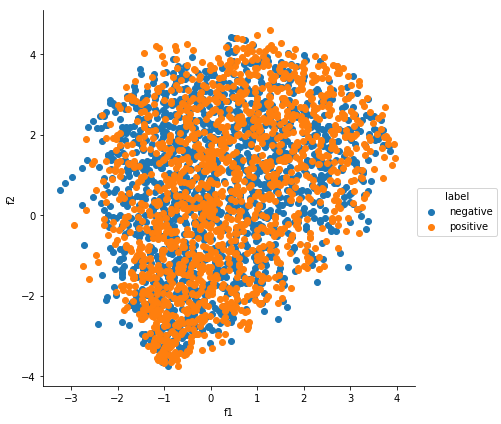

In [75]:
sns.FacetGrid(plot, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend() # p=1250

### MinMaxScaled data embedded in 2 dimensions with 1000 p

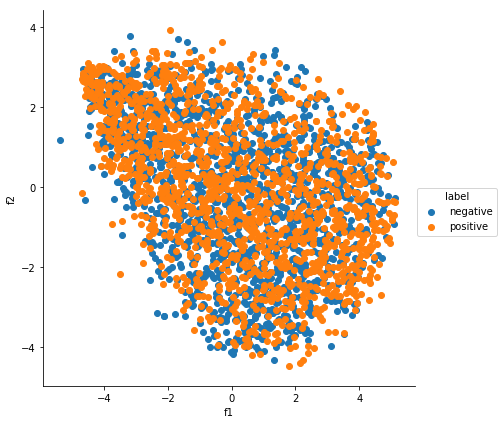

In [81]:
sns.FacetGrid(plot, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend() # p=1000

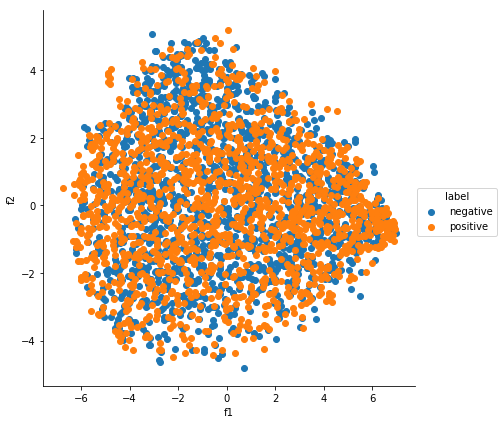

In [86]:
sns.FacetGrid(plot, hue="label", size=6).map(plt.scatter, 'f1', 'f2').add_legend() # p=700 with StandardScaler

# Conclusion
Best classification can be achieved using TF-IDF